In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sbe_vallib import BaseValidation, BinaryScorer, BinarySampler

In [3]:
from sklearn.metrics import recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


def recall_at_10(true, preds):
    return recall_score(true, preds)

def custom_test(sampler, scorer):
    pass
    

X, y = make_classification(n_samples=1000, n_classes=2,
                               n_features=5, n_informative=3, n_redundant=0,
                               random_state=0)

X = pd.DataFrame(X)
y = pd.Series(y)

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

model = LogisticRegression().fit(X_train, y_train)


sampler = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)

sampler.source_state = False

In [5]:
scorer = BinaryScorer()
scorer.score(y_test, model.predict_proba(X_test))

(array([[-2.17494019, -1.94882167,  1.51645859, -0.07984927,  0.36288949],
        [-0.29589373, -0.60658754,  1.3077079 , -0.96369018, -0.36141957],
        [ 0.90220379, -0.73748739,  2.22030551,  0.13522097, -1.15197079],
        [ 0.85614706, -1.46948688, -0.89728366, -0.67901244, -0.25092918],
        [ 1.62796243,  0.76685632,  0.76080776,  0.6368111 ,  0.27275829]]),
 array([1, 1, 1, 0, 1]),
 array([[0.20805274, 0.79194726],
        [0.2338746 , 0.7661254 ],
        [0.05374312, 0.94625688],
        [0.78686938, 0.21313062],
        [0.31976163, 0.68023837]]),
 array([[ 0.91198054,  0.50023103,  1.99986692, -0.99729165,  0.15365226],
        [-1.39793602,  1.06997912,  0.71315234, -0.65700197, -2.46928164],
        [-0.9710823 , -1.05232521,  1.19846279, -1.13319911,  0.07803667],
        [ 0.12770901,  2.96796354,  0.62891825,  0.57968663, -0.12095324],
        [-0.5096907 , -0.09935072, -1.06533583,  0.98910109, -0.13231792]]),
 array([1, 0, 1, 0, 0]),
 array([[0.0906229 , 0.9

In [7]:
stats

{'semaphore': 'grey',
 'result_dict': {'metrics': [{'accuracy_score': 0.73,
    'precision_score': 0.7319884726224783,
    'recall_score': 0.7257142857142858,
    'f1_score': 0.7288378766140602,
    'gini': 0.603591836734694},
   {'accuracy_score': 0.7542857142857143,
    'precision_score': 0.7528409090909091,
    'recall_score': 0.7571428571428571,
    'f1_score': 0.7549857549857548,
    'gini': 0.6383836734693877},
   {'accuracy_score': 0.7428571428571429,
    'precision_score': 0.7442528735632183,
    'recall_score': 0.74,
    'f1_score': 0.7421203438395415,
    'gini': 0.6369795918367347},
   {'accuracy_score': 0.72,
    'precision_score': 0.7225433526011561,
    'recall_score': 0.7142857142857143,
    'f1_score': 0.7183908045977012,
    'gini': 0.576457142857143},
   {'accuracy_score': 0.7185714285714285,
    'precision_score': 0.71671388101983,
    'recall_score': 0.7228571428571429,
    'f1_score': 0.7197724039829304,
    'gini': 0.5965061224489796},
   {'accuracy_score': 0.7385

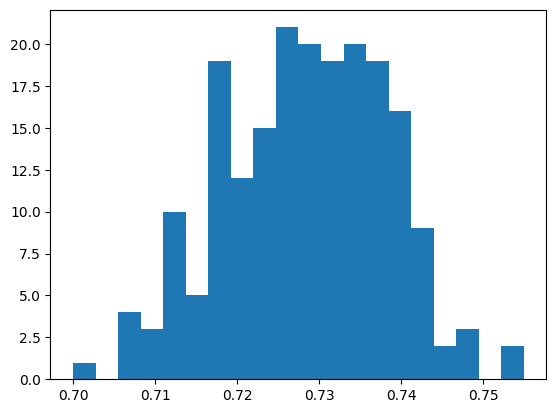

In [8]:
sampler = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)
sampler.source_state = False
sampler.set_seed(10)
sampler.oos['X'][:5], sampler.oos['y_true'][:5], sampler.oos['y_pred'][:5], sampler.train['X'][:5], sampler.train['y_true'][:5], sampler.train['y_pred'][:5]

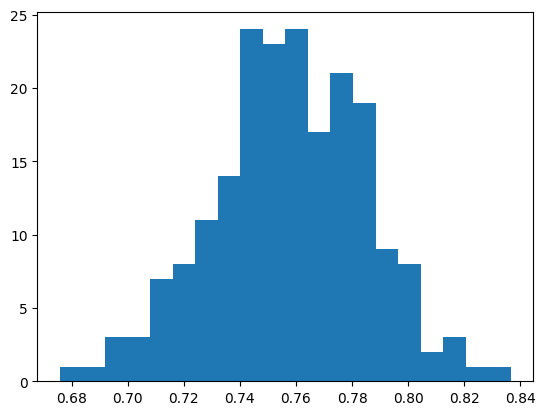

In [7]:
sampler = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=False)
sampler.oos['X'][:5], sampler.oos['y_true'][:5], sampler.oos['y_pred'][:5], sampler.train['X'][:5], sampler.train['y_true'][:5], sampler.train['y_pred'][:5]

In [9]:
from sbe_vallib.validation.table.general_tests.model_quality import test_ci
import matplotlib.pyplot as plt

sampler_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)
sampler_no_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=False)

sampler_resampling = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                        oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=False)


stats = test_ci(model, sampler_resampling, scorer)
plt.hist([i['f1_score'] for i in stats['result_dict']['metrics']], bins=20)
plt.show()
stats = test_ci(model, sampler_boot, scorer)
plt.hist([i['f1_score'] for i in stats['result_dict']['metrics']], bins=20)
plt.show()

[True, True, True, True, True, True]

Семплер работает стабильно 

In [9]:
def custom_test(model, scorer, sampler, a = 10, **kwargs):
    metrics = []
    for i in range(a):
        sampler.set_seed(i)
        train = sampler.train
        oos = sampler.oos
        model.fit(X=train["X"], y=train["y_true"])
        y_pred = model.predict_proba(oos['X'])
        metrics.append(scorer.score(oos['y_true'], y_pred))
    
    return {
        "semaphore": "grey",
        "result_dict": {'mean_f1': np.mean([i['f1_score'] for i in metrics])},
        "result_dataframes": [pd.DataFrame(metrics)],
        "result_plots": [],
    }  # сделать один в один со SberDS


custom_tests = {
    "test_0_0": {"block": "model_stability", "callable": custom_test, "params": {}},
    "test_0_0_1": {
        "block": "model_stability",
        "callable": custom_test,
        "params": {"a": 100},
    },
}


validor = BaseValidation(model, sampler, scorer, custom_tests=custom_tests)
validor.pipeline

{'tests': {'test_1_1': {'block': 'data_quality',
   'callable': <function sbe_vallib.validation.table.general_tests.model_quality.test_key_metric.test_ci(model, sampler: sbe_vallib.validation.sampler.binary_sampler.BinarySampler, scorer, n_iter=200, use_predict_proba=True, **kwargs)>,
   'params': {'n_iter': 200, 'use_predict_proba': True},
   'aggregation_most_important': True},
  'test_0_0': {'block': 'model_stability',
   'callable': <function __main__.custom_test(model, scorer, sampler, a=10, **kwargs)>,
   'params': {}},
  'test_0_0_1': {'block': 'model_stability',
   'callable': <function __main__.custom_test(model, scorer, sampler, a=10, **kwargs)>,
   'params': {'a': 100}}},
 'aggregation_mode': {},
 'aggregation_mode_by_block': {}}

In [10]:
res = validor.validate()
res.keys()

dict_keys(['test_1_1', 'test_0_0', 'test_0_0_1'])

In [11]:
res['test_0_0_1']['result_dataframes'][0]

,accuracy_score,precision_score,recall_score,f1_score,gini
0,0.773333,0.773585,0.793548,0.783439,0.652414
1,0.690000,0.676829,0.735099,0.704762,0.507356
2,0.686667,0.693252,0.719745,0.706250,0.518507
3,0.730000,0.754717,0.740741,0.747664,0.620057
4,0.713333,0.706667,0.716216,0.711409,0.592994
...,...,...,...,...,...
95,0.776667,0.777070,0.792208,0.784566,0.666341
96,0.686667,0.709459,0.673077,0.690789,0.494302
97,0.753333,0.780645,0.751553,0.765823,0.664686
98,0.773333,0.798780,0.789157,0.793939,0.713001


In [12]:
res['test_1_1']['result_dataframes'][0]

,accuracy_score,precision_score,recall_score,f1_score,gini
0,0.783333,0.784810,0.800000,0.792332,0.662380
1,0.713333,0.701863,0.748344,0.724359,0.511356
2,0.723333,0.740260,0.726115,0.733119,0.527148
3,0.746667,0.779221,0.740741,0.759494,0.628109
4,0.723333,0.721088,0.716216,0.718644,0.598595
...,...,...,...,...,...
195,0.770000,0.766871,0.801282,0.783699,0.636129
196,0.716667,0.753012,0.739645,0.746269,0.503410
197,0.763333,0.801325,0.746914,0.773163,0.615137
198,0.773333,0.780488,0.800000,0.790123,0.608214


In [181]:
from scipy.special import rel_entr

In [183]:
rel_entr(np.array([1, 2, 3]), np.array([1, 2, 1e-5]))

array([ 0.        ,  0.        , 37.83461326])

In [184]:
from sbe_vallib.validation.table.general_tests.data_quality.test_psi_factor import test_factor_psi

In [197]:
sampler_boot = BinarySampler(train={'X': X_train, 'y_true': y_train, 'y_pred': model.predict_proba(X_train)},
                             oos = {'X': X_test, 'y_true': y_test, 'y_pred': model.predict_proba(X_test)}, bootstrap=True)
results = test_factor_psi(sampler_boot, merge_upto_quantile=0.075)

[53 53 54 53 53 54 53 53 53 53 53 53 54  8]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]
[54 53 53 53 53 53 53 53 53 53 53 53 53 10]
[53 53 53 53 53 53 53 53 53 53 53 53 53 11]


In [198]:
results['result_dataframes']

,0,1,2,3,4
psi,0.053377,0.157847,0.076086,0.098411,0.114026
feat_type,Continuous,Continuous,Continuous,Continuous,Continuous
bin_count,17,17,17,17,17
hist_train,"[0.000, 53.000, 53.000, 54.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 54.000, 53.000, 53.000, 53.000, 53.000...","[0.000, 53.000, 53.000, 53.000, 53.000, 53.000..."
hist_oos,"[0.000, 26.000, 25.000, 27.000, 20.000, 17.000...","[2.000, 21.000, 18.000, 32.000, 10.000, 26.000...","[0.000, 23.000, 19.000, 22.000, 23.000, 34.000...","[0.000, 33.000, 28.000, 20.000, 22.000, 30.000...","[0.000, 34.000, 26.000, 25.000, 37.000, 11.000..."
bins,"[-inf, -4.06049, -2.00164, -1.49913, -1.04345,...","[-inf, -3.79651, -1.9582, -1.48804, -1.06203, ...","[-inf, -2.06933, -1.21815, -0.91757, -0.5612, ...","[-inf, -3.11696, -1.3541, -0.93572, -0.67664, ...","[-inf, -3.82495, -1.31814, -0.92793, -0.69203,..."
feature,0,1,2,3,4
semaphore,green,yellow,green,green,yellow


In [199]:
a, b = results['result_dataframes'][1]['hist_train'], results['result_dataframes'][1]['hist_oos']
a, b = np.array(a).astype(float), np.array(b).astype(float)


In [200]:
a / np.sum(a)

array([0.        , 0.07571429, 0.07571429, 0.07571429, 0.07571429,
       0.07571429, 0.07571429, 0.07571429, 0.07571429, 0.07571429,
       0.07571429, 0.07571429, 0.07571429, 0.07571429, 0.01571429,
       0.        ])

In [196]:
b / np.sum(b)

array([0.00666667, 0.07      , 0.04666667, 0.1       , 0.04666667,
       0.06666667, 0.07666667, 0.05      , 0.08      , 0.08666667,
       0.08333333, 0.03333333, 0.07      , 0.09666667, 0.08666667,
       0.        ])